## In this notebook:
* Analysis of TCGA dataset containing gene expression values for both normal and cancer cells.
* Cancer type is clear cell renal carcinoma (kidney cancer)
* The dataset can be found at: https://tcga.xenahubs.net/download/TCGA.KIRC.sampleMap/HiSeqV2.gz
* Brief discussion of the goal of this project and the workflow
* Data wrangling


### Analysis of TCGA gene expression dataset for clear cell renal carcinoma.

The goal of this analysis is to compare Bioconductor packages (e.g. edgeR) to pythonic techniques for conducting differential expression analysis. The analytical methodology involves comparing two groups, patients with kidney cancer and samples taken from healthy individuals. The two groups will be compared through an analysis of a gene expression dataset downloaded from The Cancer Genome Atlas (TCGA). Bioconductor uses the R statistical language and provides tools for the analysis of high throughput genomic data. R can be called from python using the rpy2 package.

Curating the data will involve conventional data wrangling techniques e.g. reading in and filtering the data,  normalization/transformation of the data, and truncating the dataset by removing genes with low expression levels. 


### Summary of the Differential Expression Analysis Workflow:

1) Involves identifying genes whose expression levels change between two sample groups.

2) To filter the genes, we can use the IQR method.

3) Filtering also requires establishing a floor for expression levels. For example, retain genes with an expression level above 3.5 in at least 25% of the samples.

5) Differential expression will be conducted using the negative binomial distribution method.

## Data wrangling

In [4]:
import pandas as pd
import os
import numpy as np
print("Current working directory" , os.getcwd()) # print out current working directory

Current working directory C:\Users\Frank


### Read in data and print header

In [5]:
os.chdir('c:/users/frank/desktop/python_springboard/datasets')

In [6]:
filename = 'HiSeqV2.csv' # assign dataset to filename object
data = pd.read_csv(filename, sep = ',') # read in csv file as pandas dataframe

In [12]:
data = data.set_index('sample')

In [13]:
data.head() # print head to verify proper formatting 

,TCGA-BP-4162-01,TCGA-CJ-5677-11,TCGA-DV-5566-01,TCGA-BP-5191-01,TCGA-BP-5200-01,TCGA-BP-4347-01,TCGA-BP-4770-01,TCGA-B0-5696-11,TCGA-BP-4762-01,TCGA-BP-4158-01,...,TCGA-B0-5104-01,TCGA-A3-3313-01,TCGA-B2-5633-01,TCGA-CJ-4872-01,TCGA-CJ-5684-01,TCGA-CJ-4886-01,TCGA-BP-5009-01,TCGA-BP-4969-01,TCGA-CZ-5461-01,TCGA-CW-5587-01
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,10.5030,10.8969,10.7612,10.2063,10.0616,10.0193,8.4364,11.1427,9.9150,10.7621,...,10.5586,9.5556,10.2652,9.4981,10.2751,9.9525,10.1273,10.8817,10.1949,10.3294
HIF3A,5.5283,6.4943,5.7842,5.0063,5.3326,7.6102,6.0422,5.9789,3.7802,7.2039,...,6.2061,4.8253,5.1680,8.6195,6.2080,6.3116,6.7446,7.8293,6.1788,6.2293
RNF17,3.8036,0.0000,0.0000,0.0000,0.0000,0.3386,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6128,0.0000
RNF10,11.4379,12.2130,11.5478,12.3439,11.5149,11.4065,12.1963,12.3946,11.3734,11.3251,...,11.7338,11.7709,11.4968,11.9561,11.7518,11.5698,12.1565,11.3048,11.5168,11.3489
RNF11,11.4180,11.8248,11.3190,10.3413,11.2923,10.9971,11.8936,11.7217,12.2329,11.2993,...,11.7629,10.2373,11.4637,11.4391,11.3992,11.4937,11.4015,10.8842,11.6230,11.5469


### Split data into two dataframes:
* The first dataframe (df1) contains expression values for normal cells
* The second dataframe (df2) contains expression values for cancer cells

In [66]:
df1 = data.filter(regex = 'sample|11$', axis =1)
# Creating new dataframe with only columns containing expression values for normal cells

In [67]:
df1.shape

(20530, 73)

In [68]:
df1.head()

,sample,TCGA-CJ-5677-11,TCGA-B0-5696-11,TCGA-CJ-5679-11,TCGA-CZ-5452-11,TCGA-B0-5712-11,TCGA-CW-5584-11,TCGA-B0-5701-11,TCGA-CZ-5461-11,TCGA-B0-5690-11,...,TCGA-CW-5580-11,TCGA-B8-5552-11,TCGA-CZ-4865-11,TCGA-CZ-4863-11,TCGA-B2-5636-11,TCGA-CW-6088-11,TCGA-CZ-5982-11,TCGA-CZ-5469-11,TCGA-CJ-5678-11,TCGA-CZ-5451-11
0,ARHGEF10L,10.8969,11.1427,10.3362,10.9979,10.6467,10.6163,10.6772,10.5352,10.9610,...,10.8603,9.4288,10.3868,10.2874,10.9476,10.8848,10.7783,10.3262,10.4025,10.9598
1,HIF3A,6.4943,5.9789,6.0228,7.8769,8.5452,5.1819,8.6367,4.9484,7.1702,...,8.3424,5.5908,7.9224,7.5603,6.4780,8.5598,6.5021,6.9556,5.5893,6.8364
2,RNF17,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5994,2.2604,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.4795
3,RNF10,12.2130,12.3946,12.3002,12.4976,12.1206,12.1293,12.1640,12.2868,12.2738,...,12.4214,11.3729,11.9933,11.9568,12.1550,12.4600,12.0911,12.3941,12.0396,12.2514
4,RNF11,11.8248,11.7217,12.0602,11.6335,11.8102,11.6994,11.5128,11.9681,11.5019,...,11.6284,12.6320,11.9769,11.9774,11.6255,11.4753,11.9079,11.7476,11.9066,11.7847


In [69]:
df1.shape

(20530, 73)

In [28]:
df2 = data.filter(regex = 'sample|01|05$', axis = 1)
# Creating new dataframe with only columns containing expression values for cancer cells

In [29]:
df2.shape

(20530, 536)

In [30]:
df2.head()

,sample,TCGA-BP-4162-01,TCGA-DV-5566-01,TCGA-BP-5191-01,TCGA-BP-5200-01,TCGA-BP-4347-01,TCGA-BP-4770-01,TCGA-BP-4762-01,TCGA-BP-4158-01,TCGA-CJ-4887-01,...,TCGA-B0-5104-01,TCGA-A3-3313-01,TCGA-B2-5633-01,TCGA-CJ-4872-01,TCGA-CJ-5684-01,TCGA-CJ-4886-01,TCGA-BP-5009-01,TCGA-BP-4969-01,TCGA-CZ-5461-01,TCGA-CW-5587-01
0,ARHGEF10L,10.5030,10.7612,10.2063,10.0616,10.0193,8.4364,9.9150,10.7621,10.5819,...,10.5586,9.5556,10.2652,9.4981,10.2751,9.9525,10.1273,10.8817,10.1949,10.3294
1,HIF3A,5.5283,5.7842,5.0063,5.3326,7.6102,6.0422,3.7802,7.2039,6.1342,...,6.2061,4.8253,5.1680,8.6195,6.2080,6.3116,6.7446,7.8293,6.1788,6.2293
2,RNF17,3.8036,0.0000,0.0000,0.0000,0.3386,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6128,0.0000
3,RNF10,11.4379,11.5478,12.3439,11.5149,11.4065,12.1963,11.3734,11.3251,11.7681,...,11.7338,11.7709,11.4968,11.9561,11.7518,11.5698,12.1565,11.3048,11.5168,11.3489
4,RNF11,11.4180,11.3190,10.3413,11.2923,10.9971,11.8936,12.2329,11.2993,10.8723,...,11.7629,10.2373,11.4637,11.4391,11.3992,11.4937,11.4015,10.8842,11.6230,11.5469


### Filter out rows with zero values

In [31]:
df1_replace = df1.replace(0.0000, np.nan)
df1_dropped = df1_replace.dropna(axis=0, how='any')
df1_dropped.shape

(15499, 73)

In [32]:
df2_replace = df2.replace(0.0000, np.nan)

In [33]:
df2_dropped = df2_replace.dropna(axis=0, how='any')
df2_dropped.shape

(12619, 536)

In [34]:
df1_set = df1_dropped.set_index('sample')
df1_set.head()

,TCGA-CJ-5677-11,TCGA-B0-5696-11,TCGA-CJ-5679-11,TCGA-CZ-5452-11,TCGA-B0-5712-11,TCGA-CW-5584-11,TCGA-B0-5701-11,TCGA-CZ-5461-11,TCGA-B0-5690-11,TCGA-CZ-5468-11,...,TCGA-CW-5580-11,TCGA-B8-5552-11,TCGA-CZ-4865-11,TCGA-CZ-4863-11,TCGA-B2-5636-11,TCGA-CW-6088-11,TCGA-CZ-5982-11,TCGA-CZ-5469-11,TCGA-CJ-5678-11,TCGA-CZ-5451-11
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,10.8969,11.1427,10.3362,10.9979,10.6467,10.6163,10.6772,10.5352,10.9610,10.8893,...,10.8603,9.4288,10.3868,10.2874,10.9476,10.8848,10.7783,10.3262,10.4025,10.9598
HIF3A,6.4943,5.9789,6.0228,7.8769,8.5452,5.1819,8.6367,4.9484,7.1702,7.2163,...,8.3424,5.5908,7.9224,7.5603,6.4780,8.5598,6.5021,6.9556,5.5893,6.8364
RNF10,12.2130,12.3946,12.3002,12.4976,12.1206,12.1293,12.1640,12.2868,12.2738,12.2829,...,12.4214,11.3729,11.9933,11.9568,12.1550,12.4600,12.0911,12.3941,12.0396,12.2514
RNF11,11.8248,11.7217,12.0602,11.6335,11.8102,11.6994,11.5128,11.9681,11.5019,11.7200,...,11.6284,12.6320,11.9769,11.9774,11.6255,11.4753,11.9079,11.7476,11.9066,11.7847
RNF13,10.7779,10.8412,10.8172,10.9679,10.7033,10.6184,10.7271,11.0801,10.9754,10.7149,...,11.0227,11.2715,11.0244,10.7831,10.8893,10.9174,10.8537,10.6932,11.0341,10.9808


In [35]:
df2_set = df2_dropped.set_index('sample')
df2_set.head()

,TCGA-BP-4162-01,TCGA-DV-5566-01,TCGA-BP-5191-01,TCGA-BP-5200-01,TCGA-BP-4347-01,TCGA-BP-4770-01,TCGA-BP-4762-01,TCGA-BP-4158-01,TCGA-CJ-4887-01,TCGA-B2-4098-01,...,TCGA-B0-5104-01,TCGA-A3-3313-01,TCGA-B2-5633-01,TCGA-CJ-4872-01,TCGA-CJ-5684-01,TCGA-CJ-4886-01,TCGA-BP-5009-01,TCGA-BP-4969-01,TCGA-CZ-5461-01,TCGA-CW-5587-01
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,10.5030,10.7612,10.2063,10.0616,10.0193,8.4364,9.9150,10.7621,10.5819,9.9260,...,10.5586,9.5556,10.2652,9.4981,10.2751,9.9525,10.1273,10.8817,10.1949,10.3294
HIF3A,5.5283,5.7842,5.0063,5.3326,7.6102,6.0422,3.7802,7.2039,6.1342,1.9065,...,6.2061,4.8253,5.1680,8.6195,6.2080,6.3116,6.7446,7.8293,6.1788,6.2293
RNF10,11.4379,11.5478,12.3439,11.5149,11.4065,12.1963,11.3734,11.3251,11.7681,11.7520,...,11.7338,11.7709,11.4968,11.9561,11.7518,11.5698,12.1565,11.3048,11.5168,11.3489
RNF11,11.4180,11.3190,10.3413,11.2923,10.9971,11.8936,12.2329,11.2993,10.8723,10.4091,...,11.7629,10.2373,11.4637,11.4391,11.3992,11.4937,11.4015,10.8842,11.6230,11.5469
RNF13,11.1265,10.7718,10.4809,10.8360,10.2079,9.7629,11.1625,10.6960,10.8856,11.5110,...,11.2131,11.5131,11.0412,11.1944,10.9735,11.1726,10.9264,10.9815,10.7416,11.0906


## Generate density plots to visualize the shape of the data

#### KDE plots of processed data separated by sample type (cancer/normal)

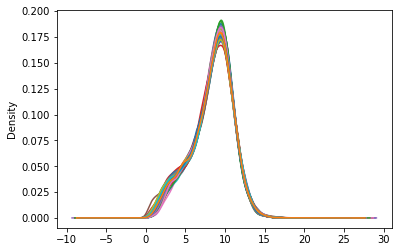

In [39]:
df1_set.plot(kind='kde', legend=False) # normal cells

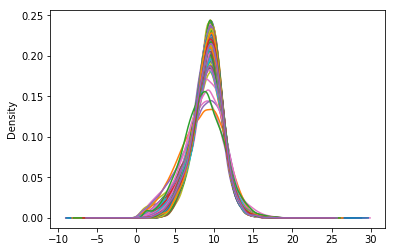

In [40]:
df2_set.plot(kind='kde', legend=False) # cancer cells

#### KDE plot of original unprocessed dataset

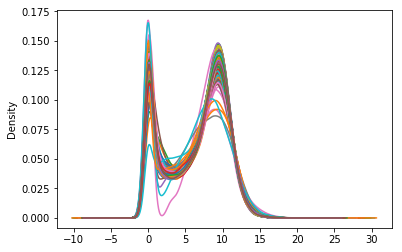

In [42]:
data.plot(kind='kde', legend=False) # entire dataset

## Pythonic differential expression analysis

In [11]:
from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Install Bioconductor using rpy2 
#### Bioconductor packages will be used for:
* Additionall processing and filtering of the data
* Differential expression analysis

In [71]:
import rpy2
from rpy2.robjects.packages import importr
base = importr('base')
base.source("http://www.bioconductor.org/biocLite.R")
biocinstaller = importr("BiocInstaller")